In [1]:
import sys
import os

root_dir = os.path.abspath("/Users/ryant/Documents/Github/digital-asset-options-pricing")
if root_dir not in sys.path:
    sys.path.append(root_dir)
os.chdir(root_dir)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

from src.functions.plotting import plot_multi_scatterplots, dual_axis_plot

# Spot

In [2]:
df_binance_btc = pd.read_parquet("/Users/ryant/Documents/Github/digital-asset-options-pricing/src/data/deribit/data/BINANCE_BTCUSDT_15m_010624_123124.parquet")
df_binance_btc['returns'] = (df_binance_btc['open'] / df_binance_btc['open'].shift(1)) - 1
df_binance_btc['log_returns'] = np.log(df_binance_btc['open'] / df_binance_btc['open'].shift(1))
df_binance_btc.tail()

,timestamp,open,high,low,close,volume,returns,log_returns
28072,1.742465e+12,85877.28,85943.74,85542.60,85545.89,285.37794,-0.001443,-0.001444
28073,1.742466e+12,85545.89,85560.61,84755.14,85246.35,789.05468,-0.003859,-0.003866
28074,1.742467e+12,85246.35,85442.23,85113.39,85293.91,318.42225,-0.003502,-0.003508
28075,1.742468e+12,85293.90,85373.28,85163.04,85173.78,132.64061,0.000558,0.000558
28076,1.742468e+12,85173.78,85320.00,85168.36,85224.00,89.30804,-0.001408,-0.001409


In [3]:
from src.models.realized_volatility import *

window = 4 * 24 * 7
scaling = np.sqrt(4 * 24 * 365)
df_binance_btc['ann_parkinson_vol'] = parkinson_volatility(df_binance_btc, window = window, scaling=scaling, high_col='high', low_col='low')
df_binance_btc['ann_garmanklass_vol'] = garman_klass_volatility(df_binance_btc, window = window, scaling=scaling, high_col='high', low_col='low', close_col='close')
df_binance_btc['ann_rogerssatchell_vol'] = rogers_satchell_volatility(df_binance_btc, window = window, scaling=scaling, high_col='high', low_col='low', close_col='close')
df_binance_btc['ann_yangzhang_vol'] = yang_zhang_volatility(df_binance_btc, window = window, scaling=scaling, high_col='high', low_col='low', close_col='close')
df_binance_btc

,timestamp,open,high,low,close,volume,returns,log_returns,ann_parkinson_vol,ann_garmanklass_vol,ann_rogerssatchell_vol,ann_yangzhang_vol
0,1.717200e+12,67540.01,67703.89,67540.00,67586.61,274.50877,NaN,NaN,NaN,NaN,NaN,NaN
1,1.717201e+12,67586.61,67586.61,67507.39,67559.73,82.60933,0.000690,0.000690,NaN,NaN,NaN,NaN
2,1.717202e+12,67559.73,67636.28,67552.00,67603.06,139.32988,-0.000398,-0.000398,NaN,NaN,NaN,NaN
3,1.717203e+12,67603.06,67689.64,67603.05,67655.66,73.42276,0.000641,0.000641,NaN,NaN,NaN,NaN
4,1.717204e+12,67655.66,67710.29,67600.00,67621.56,126.42777,0.000778,0.000778,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
28072,1.742465e+12,85877.28,85943.74,85542.60,85545.89,285.37794,-0.001443,-0.001444,0.440907,0.448550,0.459969,0.447013
28073,1.742466e+12,85545.89,85560.61,84755.14,85246.35,789.05468,-0.003859,-0.003866,0.442589,0.450570,0.462660,0.449086
28074,1.742467e+12,85246.35,85442.23,85113.39,85293.91,318.42225,-0.003502,-0.003508,0.442439,0.450507,0.462638,0.448942
28075,1.742468e+12,85293.90,85373.28,85163.04,85173.78,132.64061,0.000558,0.000558,0.442270,0.450267,0.462415,0.448802


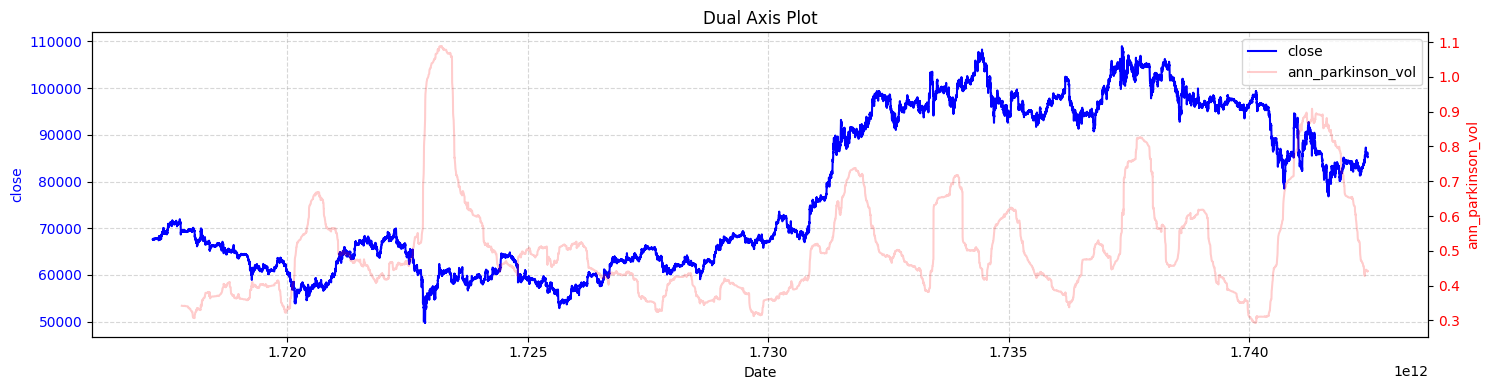

In [4]:
dual_axis_plot(
    df = df_binance_btc,
    x_axis='timestamp',
    y_left_col='close',
    y_right_col='ann_parkinson_vol'
)

# Option Prices

In [5]:
df_options_btc = pd.read_parquet('/Users/ryant/Documents/Github/digital-asset-options-pricing/src/data/deribit/data/deribit_btc_snapshot_011124_301124.parquet')
df_options_btc.head(5)

,date,open_interest,underlyer,expiration_date,claim_type,mark_price,mark_iv,bid_iv,ask_iv,exercise,settlement,strike,best_bid_price,best_ask_price,underlyer_spot,forward_price,volume,best_ask_amount,best_bid_amount,instrument_name
0,1730419200000,107.7,BTC_USD,2024-11-08T08:00:00.000Z,put,0.0810,68.41,66.03,72.38,European,cash,75000,0.0800,0.0830,70190.9,70373.62,9.0,7.8,6.6,BTC-8NOV24-75000-P
1,1730419200000,2378.0,BTC_USD,2024-11-08T08:00:00.000Z,call,0.0154,68.41,68.68,69.74,European,cash,75000,0.0155,0.0160,70190.9,70373.62,265.5,33.5,0.1,BTC-8NOV24-75000-C
2,1730419200000,97.5,BTC_USD,2024-11-08T08:00:00.000Z,put,0.0704,68.11,65.16,72.07,European,cash,74000,0.0690,0.0725,70190.9,70373.62,25.0,17.6,25.0,BTC-8NOV24-74000-P
3,1730419200000,531.4,BTC_USD,2024-11-08T08:00:00.000Z,call,0.0190,68.11,67.22,69.19,European,cash,74000,0.0185,0.0195,70190.9,70373.62,148.8,23.0,58.6,BTC-8NOV24-74000-C
4,1730419200000,174.3,BTC_USD,2024-11-08T08:00:00.000Z,put,0.0606,68.05,66.87,69.67,European,cash,73000,0.0595,0.0615,70190.9,70373.62,23.7,26.6,26.1,BTC-8NOV24-73000-P


## Data Combined

In [6]:
df_options = df_options_btc[['date', 'instrument_name', 'expiration_date', 'strike', 'claim_type', 'underlyer_spot', 'best_bid_price', 'best_ask_price', ]].copy()

df_options['datetime'] = pd.to_datetime(df_options['date'], unit='ms', utc=True)
# df_options['date'] = df_options.datetime.dt.date
df_options['hour'] = df_options.datetime.dt.hour
df_options['minute'] = df_options.datetime.dt.hour

df_options_daily = df_options[(df_options['hour'] == 0) & (df_options['minute'] == 0)].reset_index(drop=True)
df_options_daily['expiration'] = pd.to_datetime(df_options_daily['expiration_date']).dt.strftime('%d-%m-%Y')
df_options_daily['calculation_date'] = pd.to_datetime(df_options_daily['date'], unit='ms', utc=True).dt.strftime('%d-%m-%Y')
df_options_daily.loc[:,'dividend_rate'] = 0
df_options_daily.loc[:,'rf_rate'] = 0.0
df_options_daily['days_to_maturity'] = (pd.to_datetime(df_options_daily['expiration_date']) - df_options_daily['datetime']).dt.days
df_options_daily = df_options_daily.merge(df_binance_btc[['timestamp', 'ann_parkinson_vol']], left_on='date', right_on='timestamp').drop(columns=['timestamp']).rename(columns={'ann_parkinson_vol': 'sigma'})
df_options_daily = df_options_daily.rename(columns = {'underlyer_spot' : 'underlying'})
df_options_daily[['strike', 'underlying']] = df_options_daily[['strike', 'underlying']].astype(float)
df_options_daily['lowest_bid'] = df_options_daily['best_bid_price'] * df_options_daily['underlying']
df_options_daily['highest_ask'] = df_options_daily['best_ask_price'] * df_options_daily['underlying']
df_options_daily

,date,instrument_name,expiration_date,strike,claim_type,underlying,best_bid_price,best_ask_price,datetime,hour,minute,expiration,calculation_date,dividend_rate,rf_rate,days_to_maturity,sigma,lowest_bid,highest_ask
0,1730419200000,BTC-8NOV24-75000-P,2024-11-08T08:00:00.000Z,75000.0,put,70190.90,0.0800,0.0830,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,5615.272000,5825.844700
1,1730419200000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70190.90,0.0155,0.0160,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,1087.958950,1123.054400
2,1730419200000,BTC-8NOV24-74000-P,2024-11-08T08:00:00.000Z,74000.0,put,70190.90,0.0690,0.0725,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,4843.172100,5088.840250
3,1730419200000,BTC-8NOV24-74000-C,2024-11-08T08:00:00.000Z,74000.0,call,70190.90,0.0185,0.0195,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,1298.531650,1368.722550
4,1730419200000,BTC-8NOV24-73000-P,2024-11-08T08:00:00.000Z,73000.0,put,70190.90,0.0595,0.0615,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,4176.358550,4316.740350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102655,1732927500000,BTC-26SEP25-110000-C,2025-09-26T08:00:00.000Z,110000.0,call,97065.83,0.2035,0.2090,2024-11-30 00:45:00+00:00,0,0,26-09-2025,30-11-2024,0,0.0,300,0.457788,19752.896405,20286.758470
102656,1732927500000,BTC-26SEP25-105000-P,2025-09-26T08:00:00.000Z,105000.0,put,97065.83,0.1935,0.2050,2024-11-30 00:45:00+00:00,0,0,26-09-2025,30-11-2024,0,0.0,300,0.457788,18782.238105,19898.495150
102657,1732927500000,BTC-26SEP25-105000-C,2025-09-26T08:00:00.000Z,105000.0,call,97064.19,0.2205,0.2265,2024-11-30 00:45:00+00:00,0,0,26-09-2025,30-11-2024,0,0.0,300,0.457788,21402.653895,21985.039035
102658,1732927500000,BTC-26SEP25-100000-P,2025-09-26T08:00:00.000Z,100000.0,put,97065.83,0.1705,0.1770,2024-11-30 00:45:00+00:00,0,0,26-09-2025,30-11-2024,0,0.0,300,0.457788,16549.724015,17180.651910


# Pricing (One Timestamp)

In [ ]:
from src.pricer import AnalyticEuropeanPricer

df_options_single_call = df_options_daily[(df_options_daily['date'] == 1730419200000) & (df_options_daily['claim_type'] == 'call')]
df_options_single_call

,date,instrument_name,expiration_date,strike,claim_type,underlying,best_bid_price,best_ask_price,datetime,hour,minute,expiration,calculation_date,dividend_rate,rf_rate,days_to_maturity,sigma,lowest_bid,highest_ask
1,1730419200000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70190.9,0.0155,0.0160,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,1087.95895,1123.05440
3,1730419200000,BTC-8NOV24-74000-C,2024-11-08T08:00:00.000Z,74000.0,call,70190.9,0.0185,0.0195,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,1298.53165,1368.72255
5,1730419200000,BTC-8NOV24-73000-C,2024-11-08T08:00:00.000Z,73000.0,call,70190.9,0.0230,0.0235,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,1614.39070,1649.48615
7,1730419200000,BTC-8NOV24-72000-C,2024-11-08T08:00:00.000Z,72000.0,call,70190.9,0.0280,0.0285,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,1965.34520,2000.44065
9,1730419200000,BTC-8NOV24-71000-C,2024-11-08T08:00:00.000Z,71000.0,call,70190.9,0.0340,0.0350,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,2386.49060,2456.68150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,1730419200000,BTC-26SEP25-140000-C,2025-09-26T08:00:00.000Z,140000.0,call,70190.9,0.0535,0.0575,2024-11-01 00:00:00+00:00,0,0,26-09-2025,01-11-2024,0,0.0,329,0.384502,3755.21315,4035.97675
861,1730419200000,BTC-26SEP25-130000-C,2025-09-26T08:00:00.000Z,130000.0,call,70190.9,0.0645,0.0685,2024-11-01 00:00:00+00:00,0,0,26-09-2025,01-11-2024,0,0.0,329,0.384502,4527.31305,4808.07665
863,1730419200000,BTC-26SEP25-120000-C,2025-09-26T08:00:00.000Z,120000.0,call,70190.9,0.0785,0.0830,2024-11-01 00:00:00+00:00,0,0,26-09-2025,01-11-2024,0,0.0,329,0.384502,5509.98565,5825.84470
865,1730419200000,BTC-26SEP25-110000-C,2025-09-26T08:00:00.000Z,110000.0,call,70190.9,0.0965,0.1010,2024-11-01 00:00:00+00:00,0,0,26-09-2025,01-11-2024,0,0.0,329,0.384502,6773.42185,7089.28090


# Pricing (1 Instrument)

In [15]:
df_options_daily.iloc[1]['instrument_name']

'BTC-8NOV24-75000-C'

In [16]:
instrument = df_options_daily.iloc[1]['instrument_name']
pricer = AnalyticEuropeanPricer(option_type=ql.Option.Call)
df_options_single_timestamp = df_options_daily[df_options_daily['instrument_name'] == instrument].reset_index(drop=True)
df_options_single_timestamp

Created AnalyticEuropeanPricer and option type 1


,date,instrument_name,expiration_date,strike,claim_type,underlying,best_bid_price,best_ask_price,datetime,hour,minute,expiration,calculation_date,dividend_rate,rf_rate,days_to_maturity,sigma,lowest_bid,highest_ask
0,1730419200000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70190.90,0.0155,0.0160,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,1087.958950,1123.054400
1,1730420100000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70325.50,0.0155,0.0160,2024-11-01 00:15:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384465,1090.045250,1125.208000
2,1730421000000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70315.74,0.0155,0.0160,2024-11-01 00:30:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384678,1089.893970,1125.051840
3,1730421900000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70139.02,0.0145,0.0150,2024-11-01 00:45:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384787,1017.015790,1052.085300
4,1730505600000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69477.07,0.0115,0.0125,2024-11-02 00:00:00+00:00,0,0,08-11-2024,02-11-2024,0,0.0,6,0.391699,798.986305,868.463375
5,1730506500000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69561.32,0.0120,0.0130,2024-11-02 00:15:00+00:00,0,0,08-11-2024,02-11-2024,0,0.0,6,0.391431,834.735840,904.297160
6,1730507400000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69592.59,0.0120,0.0130,2024-11-02 00:30:00+00:00,0,0,08-11-2024,02-11-2024,0,0.0,6,0.391296,835.111080,904.703670
7,1730508300000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69579.14,0.0120,0.0130,2024-11-02 00:45:00+00:00,0,0,08-11-2024,02-11-2024,0,0.0,6,0.391234,834.949680,904.528820
8,1730592000000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69338.77,0.0105,0.0110,2024-11-03 00:00:00+00:00,0,0,08-11-2024,03-11-2024,0,0.0,5,0.391344,728.057085,762.726470
9,1730592900000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69312.17,0.0105,0.0110,2024-11-03 00:15:00+00:00,0,0,08-11-2024,03-11-2024,0,0.0,5,0.391347,727.777785,762.433870


In [17]:
df_options_single_timestamp['price'] = df_options_single_timestamp.apply(lambda x: pricer.price(
    calculation_date = ql.Date(x['datetime'].day, x['datetime'].month, x['datetime'].year),
    underlying = x['underlying'],
    strike = x['strike'],
    sigma = x['sigma'],
    rf_rate = x['rf_rate'],
    days_to_maturity = x['days_to_maturity'],
    div = x['dividend_rate']
), axis=1)
df_options_single_timestamp

,date,instrument_name,expiration_date,strike,claim_type,underlying,best_bid_price,best_ask_price,datetime,hour,minute,expiration,calculation_date,dividend_rate,rf_rate,days_to_maturity,sigma,lowest_bid,highest_ask,price
0,1730419200000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70190.90,0.0155,0.0160,2024-11-01 00:00:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384502,1087.958950,1123.054400,197.626441
1,1730420100000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70325.50,0.0155,0.0160,2024-11-01 00:15:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384465,1090.045250,1125.208000,213.045772
2,1730421000000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70315.74,0.0155,0.0160,2024-11-01 00:30:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384678,1089.893970,1125.051840,212.301762
3,1730421900000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,70139.02,0.0145,0.0150,2024-11-01 00:45:00+00:00,0,0,08-11-2024,01-11-2024,0,0.0,7,0.384787,1017.015790,1052.085300,192.420593
4,1730505600000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69477.07,0.0115,0.0125,2024-11-02 00:00:00+00:00,0,0,08-11-2024,02-11-2024,0,0.0,6,0.391699,798.986305,868.463375,100.747547
5,1730506500000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69561.32,0.0120,0.0130,2024-11-02 00:15:00+00:00,0,0,08-11-2024,02-11-2024,0,0.0,6,0.391431,834.735840,904.297160,106.209860
6,1730507400000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69592.59,0.0120,0.0130,2024-11-02 00:30:00+00:00,0,0,08-11-2024,02-11-2024,0,0.0,6,0.391296,835.111080,904.703670,108.257882
7,1730508300000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69579.14,0.0120,0.0130,2024-11-02 00:45:00+00:00,0,0,08-11-2024,02-11-2024,0,0.0,6,0.391234,834.949680,904.528820,107.227953
8,1730592000000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69338.77,0.0105,0.0110,2024-11-03 00:00:00+00:00,0,0,08-11-2024,03-11-2024,0,0.0,5,0.391344,728.057085,762.726470,58.435546
9,1730592900000,BTC-8NOV24-75000-C,2024-11-08T08:00:00.000Z,75000.0,call,69312.17,0.0105,0.0110,2024-11-03 00:15:00+00:00,0,0,08-11-2024,03-11-2024,0,0.0,5,0.391347,727.777785,762.433870,57.239039


<Axes: title={'center': 'Option Prices'}>

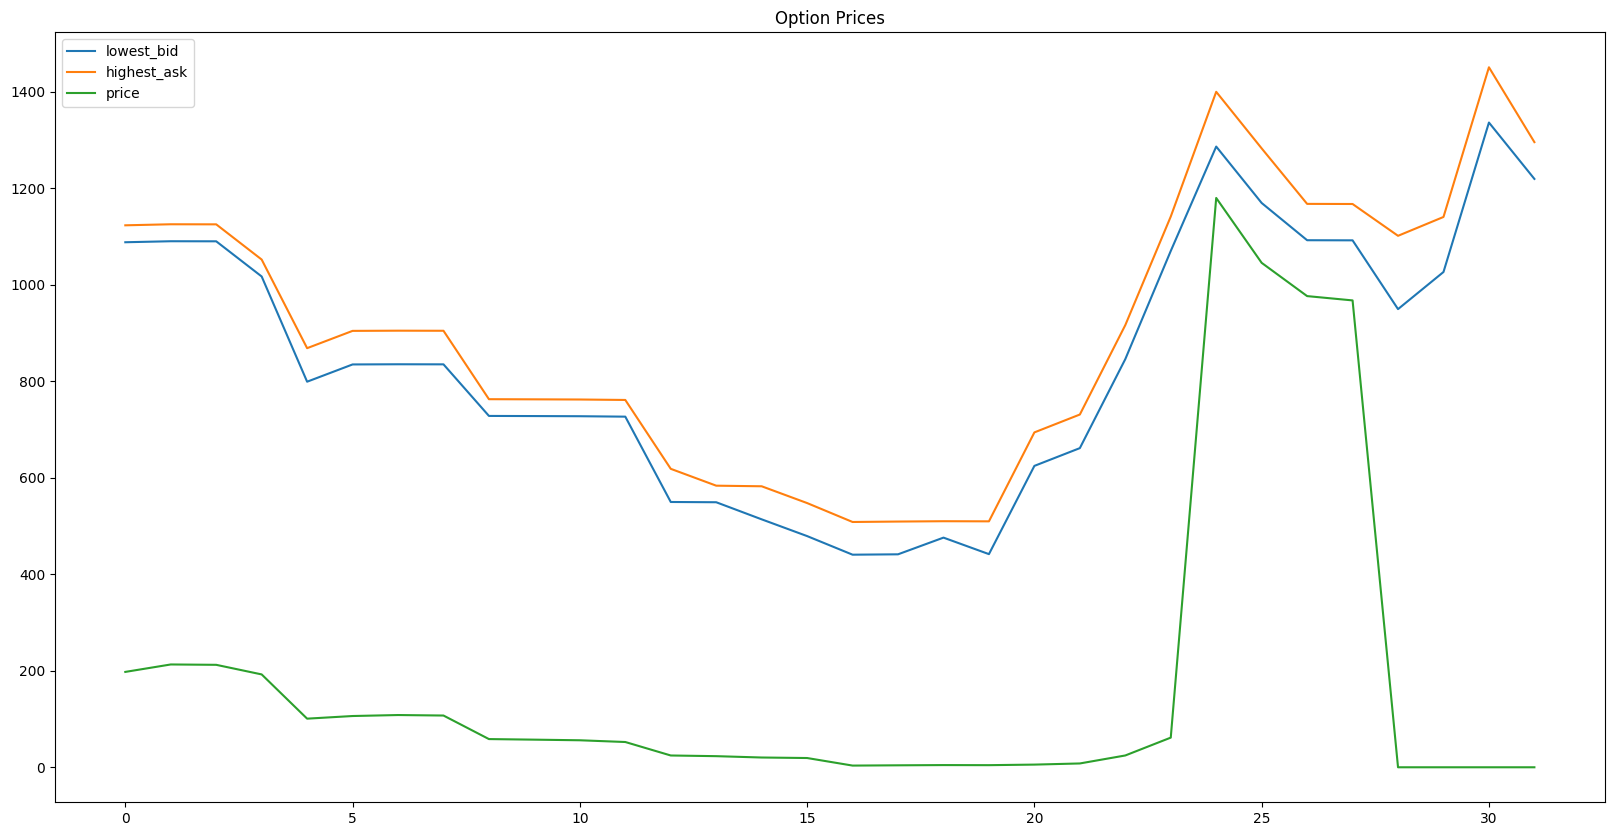

In [18]:
df_options_single_timestamp[['lowest_bid', 'highest_ask', 'price']].plot(
    kind='line',
    figsize=(20, 10),
    title='Option Prices'
)